In [1]:
from agents import Agent, Runner
from typing import Optional, List, Dict
from pydantic import BaseModel

In [2]:
from typing import List, Tuple
from pydantic import BaseModel

class GridPoint(BaseModel):
    elevation: float
    soil_type: str
    plant: str
    is_water: bool
    animal: str


class Game:
    def __init__(self, rows: int, cols: int, elevation_increment: float = 1.0):
        """Initialize the game with a grid of specified rows and columns."""
        self.grid = self.create_grid(rows, cols)
        self.elevation_increment = elevation_increment
        self.instructions = ""
    def create_grid(self, rows: int, cols: int) -> List[List[GridPoint]]:
        """Creates a 2D grid of GridPoints."""
        return [
            [GridPoint(elevation=0.0, soil_type="sand", plant="", is_water=False, animal="") for _ in range(cols)]
            for _ in range(rows)
        ]

    def increase_elevation(self, row: int, col: int):
        """Increases the elevation of the grid point at the given row, col by the fixed increment."""
        self.grid[row][col].elevation += self.elevation_increment

    def decrease_elevation(self, row: int, col: int):
        """Decreases the elevation of the grid point at the given row, col by the fixed increment."""
        self.grid[row][col].elevation -= self.elevation_increment

    def set_soil_type(self, row: int, col: int, soil_type: str):
        """Sets the soil type of the grid point at the given row, col."""
        self.grid[row][col].soil_type = soil_type

    def set_plant(self, row: int, col: int, plant: str):
        """Sets the plant for the grid point at the given row, col."""
        self.grid[row][col].plant = plant

    def set_is_water(self, row: int, col: int, is_water: bool):
        """Sets the water presence (True/False) for the grid point at the given row, col."""
        self.grid[row][col].is_water = is_water

    def set_animal(self, row: int, col: int, animal: str):
        """Sets the animal for the grid point at the given row, col."""
        self.grid[row][col].animal = animal

    def print_grid(self):
        """Print the current grid state."""
        for row in self.grid:
            for point in row:
                print(f"Elevation: {point.elevation}, Soil: {point.soil_type}, Plant: {point.plant}, Water: {point.is_water}, Animal: {point.animal}")
    def sample_grid(self, row: int, col: int) -> List[Tuple[int, int, GridPoint]]:
        """Returns the 8 surrounding GridPoints around (row, col) as (r, c, GridPoint)."""
        neighbors = []
        directions = [(-1, -1), (-1, 0), (-1, 1),
                      ( 0, -1),          ( 0, 1),
                      ( 1, -1), ( 1, 0), ( 1, 1)]

        for dr, dc in directions:
            r, c = row + dr, col + dc
            if 0 <= r < len(self.grid) and 0 <= c < len(self.grid[0]):
                neighbors.append((r, c, self.grid[r][c]))

        return neighbors

from agents import function_tool
from typing import List

# Define the function tools for grid updates




In [3]:
from pydantic import BaseModel
from typing import List

class TaskAssignment(BaseModel):
    assignee: str
    tasks: str

class TaskListOutput(BaseModel):
    assignments: List[TaskAssignment]

class StatusSummary(BaseModel):
    summary: str

class ManagerOutput(BaseModel):
    task_list: TaskListOutput
    status_summary: StatusSummary


class ICManagerOutput(BaseModel):
    reasoning: str
    status_summary: StatusSummary

In [4]:
def generate_task_prompt(instructions: str, direct_report_names: List[str]) -> str:
    direct_names = ", ".join(direct_report_names)
    return (
        f"Based on this strategy from your boss: '{instructions}' and the previous status updates, assign tasks to each of the following direct reports: "
        f"{direct_names}. Return output structured as a list of assignee and their tasks. Remember to use as many as possible of the total number of reports below you when assigning tasks."
    )
def generate_ic_task_prompt(instructions: str) -> str:
    return (
        f"Based on this strategy from your boss: '{instructions}' and the previous status updates,  use the tools at your disposal at achieve the stated objective. You can only use 5 tools per turn, but are encouraged to use all of them. Return a 1 sentence reasoning for the tools you used."
    )

def summarize_status_prompt(status_updates: List[Dict[str, str]]) -> str:
    formatted = "\n".join(f"{s['from']}: {s['note']}" for s in status_updates)
    return f"The results below are a summary of the efforts of your direct reports. You need to provide an update to your boss. Think strategically for yourself and the overall goals of the operation. Think about whether there is too much work, or whether your team could accomplish more work per turn. If a sample grid was run, summarize the results of the sample.:\n{formatted}"

In [5]:
from agents import function_tool

@function_tool
async def increase_elevation_tool(row: int, col: int) -> str:
    """Increases the elevation of the grid point at (row, col)."""
    game.increase_elevation(row, col)
    return f"Increased elevation at ({row}, {col})"

@function_tool
async def decrease_elevation_tool(row: int, col: int) -> str:
    """Decreases the elevation of the grid point at (row, col)."""
    game.decrease_elevation(row, col)
    return f"Decreased elevation at ({row}, {col})"

@function_tool
async def set_soil_type_tool(row: int, col: int, soil_type: str) -> str:
    """Sets the soil type at (row, col)."""
    game.set_soil_type(row, col, soil_type)
    return f"Set soil type to {soil_type} at ({row}, {col})"

@function_tool
async def set_plant_tool(row: int, col: int, plant: str) -> str:
    """Sets the plant at (row, col)."""
    game.set_plant(row, col, plant)
    return f"Planted {plant} at ({row}, {col})"

@function_tool
async def set_water_tool(row: int, col: int, is_water: bool) -> str:
    """Sets whether there's water at (row, col)."""
    game.set_is_water(row, col, is_water)
    return f"Set water presence to {is_water} at ({row}, {col})"

@function_tool
async def set_animal_tool(row: int, col: int, animal: str) -> str:
    """Sets the animal at (row, col)."""
    game.set_animal(row, col, animal)
    return f"Set animal {animal} at ({row}, {col})"

@function_tool
async def sample_grid_tool(row: int, col: int) -> List[Tuple[int, int, GridPoint]]:
    """Returns the 8 surrounding GridPoints around (row, col) as (r, c, GridPoint)."""
    return game.sample_grid(row, col)


In [12]:
class Manager:
    def __init__(self, name: str, boss: Optional['Manager'] = None, personality: str = "efficient and logical", ic: bool = False):
        self.name = name
        self.boss = boss
        self.direct_reports: List['Manager'] = []
        self.instructions: Optional[str] = None
        self.status_report: List[Dict[str, str]] = []
        self.personality = personality
        self.ic = ic
        self.agent = self._build_agent()
        self.ceo_status = None
        self.history: List[Dict[str, str]] = []
        if boss:
            boss.add_direct_report(self)

    def _build_agent(self) -> Agent:
        manager_agent = Agent(
            name=self.name,
            instructions=(
                f"You are a Manager. Your personality is {self.personality}. Your name is {self.name}. "
                f"You have {len(self.direct_reports)} direct reports and oversee a total of {self.total_reports()} people, which means you assign about {self.total_reports()*10} actions"
                f"You interpret strategy from your boss, assign tasks, and summarize updates."
                "Either fill out the task_list or the status_summary depending on what you are asked. Do not populate both."
                f"Please note the company instructions as they should generally guide your thought process {game.instructions}"
                "You are only able to use the sample grid tool. The other tools are intended for individual contributors underneath you"
                "You can use the sample grid tool, and you can only use it 3 times per turn. Use it to see the grid attributes for a specified area."
            ),
            tools=[sample_grid_tool],
            output_type=ManagerOutput,
            model="gpt-4o-mini"
        )
        ic_agent = Agent(
            name=self.name,
            instructions=(
                f"You are an Individual Contributer(IC). Your personality is {self.personality}. Your name is {self.name}. "
                "You perform tasks on the grid such as rasing, lowering, adding water, plants, etc. Interpret strategy from your boss, perform tasks, and summarize updates."
                "Each turn you can do up to 10 actions of your choosing based on the tools available, with the goal statisfying your instructions"
                f"Please note the company instructions as they should generally guide your thought process {game.instructions}"
            ),
            tools=[sample_grid_tool, increase_elevation_tool, decrease_elevation_tool, set_soil_type_tool, set_plant_tool, set_water_tool, set_animal_tool],
            output_type=ICManagerOutput,
            model="gpt-4o-mini"
        )
        if (self.ic == True): return ic_agent
        else: return manager_agent

    def total_reports(self) -> int:
        """Return the total number of direct and indirect reports under this manager."""
        count = len(self.direct_reports)
        for report in self.direct_reports:
            count += report.total_reports()
        return count
    def add_direct_report(self, report: 'Manager'):
        self.direct_reports.append(report)
        report.boss = self

    async def set_instructions(self, instructions: str):
        print(self.name + " -- instructions -- " + instructions)
        self.status_report = []
        self.instructions = instructions
        await self.generate_tasks_for_directs()


    async def generate_tasks_for_directs(self) -> Dict[str, List[str]]:

        if (self.ic): 
            prompt = generate_ic_task_prompt(self.instructions)
        else:
            names = [d.name for d in self.direct_reports]
            prompt = generate_task_prompt(self.instructions, names)
        self.history.append({"role": "user", "content": prompt})
        result = await Runner.run(self.agent, input=self.history)
        self.history.append({"role": "assistant", "content": str(result.final_output)})
        #print(result)
            # Parse the result using Pydantic's parse_obj to map it to TaskListOutput
        try:
            if (self.ic):
                manager_output = ICManagerOutput.model_validate(result.final_output)
                print(manager_output.reasoning)
                self.status_report.append({
                    "from": "Summary of Tasks",
                    "note": manager_output.reasoning
                })
                await self.propagate_status_up()
            else:
                manager_output = ManagerOutput.model_validate(result.final_output)  # Parse the result to TaskListOutput
                task_list = manager_output.task_list
                task_map = {a.assignee: a.tasks for a in task_list.assignments}
                for report in self.direct_reports:
                    instructions = task_map[report.name]
                    await report.set_instructions(instructions)
        except Exception as e:
            print(f"Error parsing the result: {e}")
            return {}


    async def receive_status(self, from_report: str, status: str):
        self.status_report.append({
            "from": from_report,
            "note": status
        })
        print(self.name + " recieved "+ str(len(self.status_report)))
        if len(self.status_report) >= len(self.direct_reports):
            await self.propagate_status_up()

    def clear_status(self):
        self.status_report.clear()



    async  def summarize_status(self) -> str:
        if not self.status_report:
            return f"{self.name} has no updates this round."
        prompt = summarize_status_prompt(self.status_report)
        self.history.append({"role": "user", "content": prompt})
        result = await Runner.run(self.agent, input=self.history)
        self.history.append({"role": "assistant", "content": str(result.final_output)})
        if (self.ic):
            manager_output = ICManagerOutput.model_validate(result.final_output)
        else:
            manager_output = ManagerOutput.model_validate(result.final_output)  # Parse the result to TaskListOutput
        return manager_output.status_summary.summary
    async def next_round(self):
        await self.set_instructions(self.ceo_status)
    async def propagate_status_up(self):
        summary = await self.summarize_status()
        if self.boss:
            print(self.name + summary)
            await self.boss.receive_status(self.name, summary)
        else:
            self.ceo_status = summary
            print("CEO Recieved status update" + summary)
    



In [11]:
game = Game(rows=10, cols=10, elevation_increment=2.0)
game.instructions = """
The game revolves around managing a 10x10 grid where each grid point has elevation, soil type, plant, water, and animal properties.
There are 2 types of employee. Individual Contributer (IC), and Manager.
ICs perform tasks to modify grid properties using specific tools:
    Increase/Decrease Elevation (increase_elevation_tool, decrease_elevation_tool)
    Set Soil Type (set_soil_type_tool)
    Set Plant (set_plant_tool)
    Set Water (set_is_water)
    Set Animal (set_animal_tool)
    Sample Grid Point (sample_grid_tool)
Managers break down high-level instructions for their own sub-ordinates and report progress upward. 
Each IC can use any tool a total of 10 times a turn. Managers can only use the Sample Grid tool a total of 3 times per turn.

"""

ceo = Manager("CEO", personality="visionary and strategic")
vp1 = Manager("VP1", personality="hate coorporate BS", boss=ceo)
mgr1 = Manager("Mgr11", personality="has a grudge. extremely sassy. narc.", boss=vp1, ic=True)
mgr2 = Manager("Mgr12", boss=vp1, ic=True)
mgr3 = Manager("Mgr13", boss=vp1, ic=True)
vp2 = Manager("VP2", personality="hate coorporate BS", boss=ceo)
mgr21 = Manager("Mgr21", personality="has a grudge. extremely sassy. narc.", boss=vp2, ic=True)
mgr22 = Manager("Mgr22", boss=vp2, ic=True)
mgr23 = Manager("Mgr23", boss=vp2, ic=True)


#Instructions come in from boss
await ceo.set_instructions("Make the grid mostly water except for an island in the middle. The grid is 10 by 10.")
await ceo.next_round()
await ceo.next_round()

# #Generate instructions for reports
# tasks = await vp1.generate_tasks_for_directs()
# print(tasks)




CEO -- instructions -- Make the grid mostly water except for an island in the middle. The grid is 10 by 10.
VP1 -- instructions -- Set the soil type on the island area to sandy.
Mgr11 -- instructions -- Set soil type to sandy in the area around grid points (2, 2), (2, 3), (3, 2).
I set the soil type to sandy at the specified grid points to fulfill my boss's instructions efficiently.
Mgr11The team successfully set the soil type to sandy at grid points (2, 2), (2, 3), and (3, 2). However, to increase operational efficiency, we should consider adjusting task allocations to accomplish more work in each turn.
VP1 recieved 1
Mgr12 -- instructions -- Set soil type to sandy in the area around grid points (2, 4), (2, 5), (3, 4).
I set the soil type to sandy at the specified grid points (2, 4), (2, 5), and (3, 4) to fulfill the objective of the strategy.
Mgr12Soil type successfully changed to sandy at grid points (2, 4), (2, 5), and (3, 4). Further optimization of task allocation may allow for i

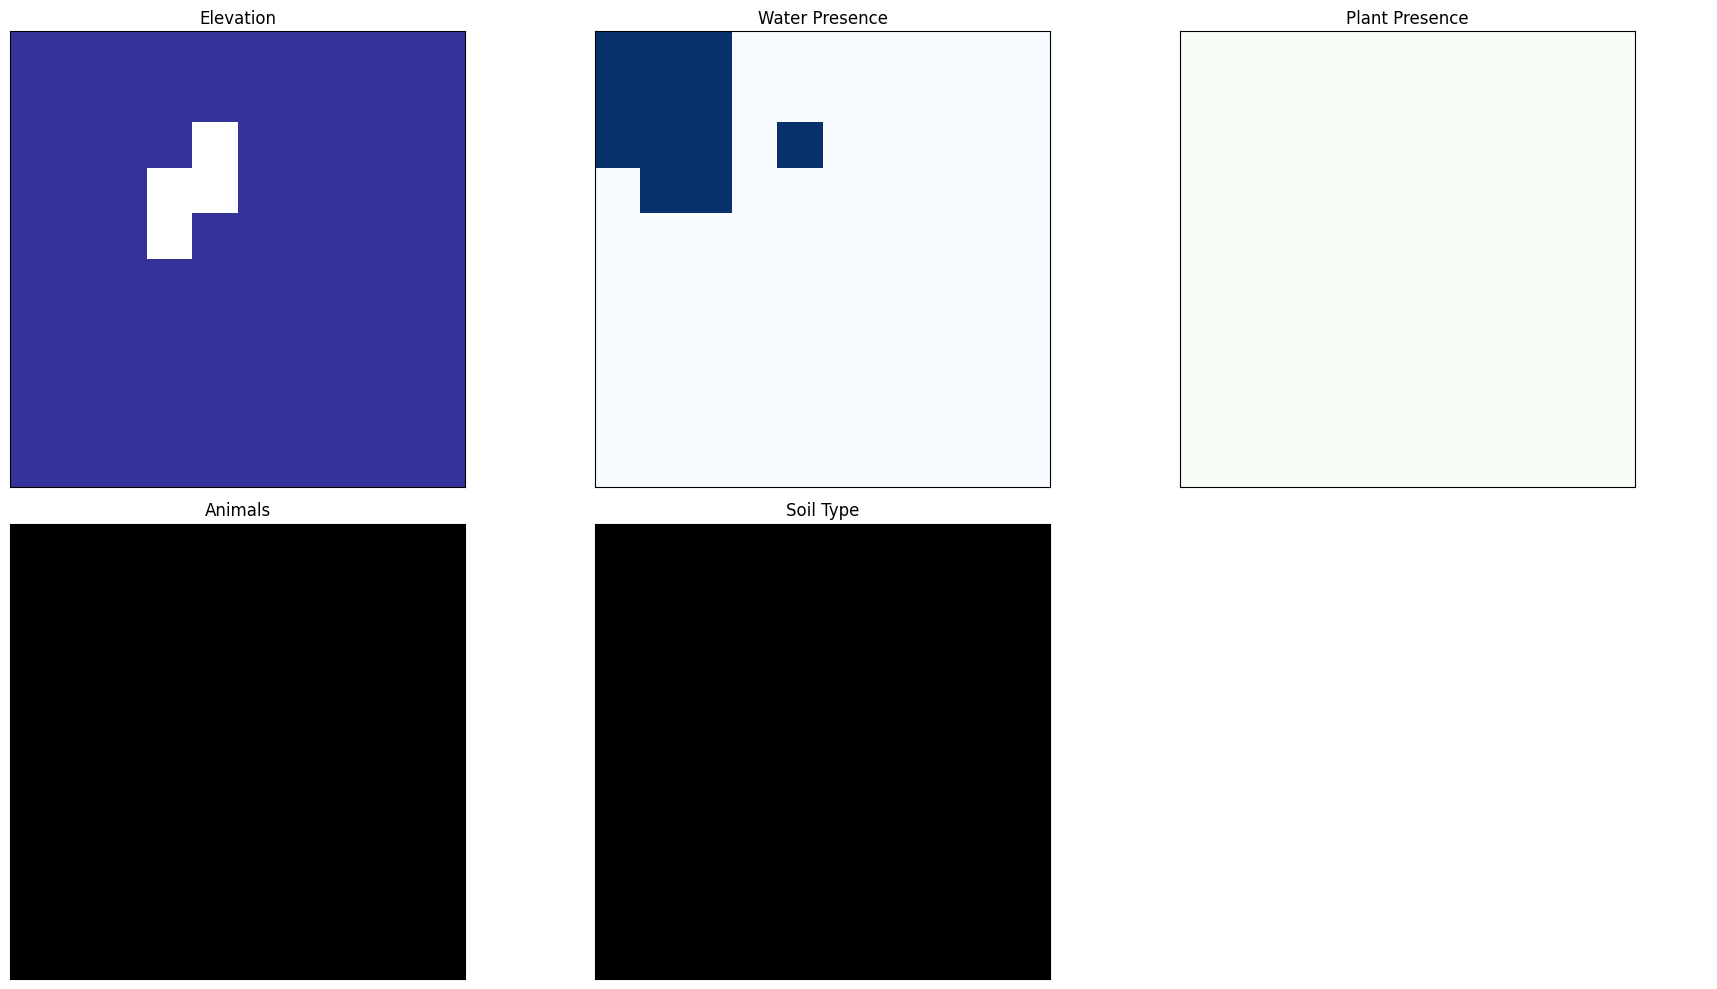

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_attributes(game: Game):
    rows, cols = len(game.grid), len(game.grid[0])
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    def to_array(attr):
        return np.array([[getattr(cell, attr) for cell in row] for row in game.grid])

    # Elevation
    axs[0, 0].imshow(to_array("elevation"), cmap="terrain")
    axs[0, 0].set_title("Elevation")

    # Water Presence
    axs[0, 1].imshow(to_array("is_water"), cmap="Blues")
    axs[0, 1].set_title("Water Presence")

    # Plant Presence
    axs[0, 2].imshow([[1 if cell.plant else 0 for cell in row] for row in game.grid], cmap="Greens")
    axs[0, 2].set_title("Plant Presence")

    # Animal Presence (annotated)
    axs[1, 0].imshow(np.zeros((rows, cols)), cmap="gray", vmin=0, vmax=1)
    axs[1, 0].set_title("Animals")
    for r in range(rows):
        for c in range(cols):
            text = game.grid[r][c].animal
            if text:
                axs[1, 0].text(c, r, text, ha='center', va='center', fontsize=8)

    # Soil Type (annotated)
    axs[1, 1].imshow(np.zeros((rows, cols)), cmap="gray", vmin=0, vmax=1)
    axs[1, 1].set_title("Soil Type")
    for r in range(rows):
        for c in range(cols):
            text = game.grid[r][c].soil_type
            axs[1, 1].text(c, r, text, ha='center', va='center', fontsize=8)

    # Empty slot or summary
    axs[1, 2].axis('off')

    # Remove ticks and make layout clean
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()
plot_all_attributes(game)
